In [1]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import scipy.stats as stats

# jupyter magic to display plots directly in the notebook
%matplotlib inline

# use vector graphics format for nicer plots
%config Inline.Backend.figure_format = 'svg'

np.random.seed(1234)

In [2]:
# Set the coefficients:
M = 5000
N = 50
alpha = 1
beta = 1

In [3]:
def ols(y,X, residuals, add_constant = False):
    """
    Implements crude OLS estimators and 
    custom checks for the assignment question
    """
    
    is_nonzero_const = np.ptp(X, axis = 0) == 0 # checks difference between rows to see if a constant column is present or not
    if is_nonzero_const.any():
        print("Data already contains a constant")
        
    if add_constant:
        # check if it already has a constant
        if is_nonzero_const.any():
            pass # do nothing
        else:
            # by default, we'll prepend ones 
            X = [np.ones(X.shape[0]), X]
            X = np.column_stack(X)
        
    # beta = (X.T * X)^{-1} * X.T * y
    betas = np.dot(np.linalg.inv(np.dot(np.transpose(X), X)), np.dot(np.transpose(X), y))
    
    # estimate the standard errors
    sigma2_hat = sum(residuals ** 2) / (X.shape[0] - X.shape[1])
    var_beta = sigma2_hat * np.linalg.inv(np.dot(np.transpose(X), X))
    # get OLS standard error
    ols_std_err = np.sqrt(np.diag(var_beta))

    alpha_hat = {'ols_estimate': betas[0], 'ols_std_error': ols_std_err[0]}
    beta_hat = {'ols_estimate': betas[1], 'ols_std_error': ols_std_err[1]}
    
    return alpha_hat, beta_hat

In [4]:
def generate_cov(dim, _corr):
    acc  = []
    for i in range(dim):
        row = np.ones((1, dim)) * _corr # simple since we're dealing with standard normal
        row[0][i] = 1
        acc.append(row)
        
    return np.concatenate(acc, axis = 0)

In [5]:
def generate_random_variables(M, N, method):
    if method == 'std_normal':
        x = np.random.normal(loc = 0, scale = 1, size = (M, N))
        e = np.random.normal(loc = 0, scale = 1, size = (M, N))
    elif method == 'correlated_normal':
        cov_mat = generate_cov(dim = 2, _corr = 0.5)
        print("Covariance Matrix: \n")
        print(cov_mat)
        RV = np.random.multivariate_normal(mean = [0, 0], cov = cov_mat, size = (M, N))
        x = RV[:,:,0]
        e = RV[:,:,1]
    elif method == 't_dist':
        x = np.random.standard_t(df = 5, size = (M, N))
        e = np.random.standard_t(df = 5, size = (M, N))
    elif method == 'uniform_dist':
        x = np.random.uniform(low = 0.0, high = 1.0, size = (M, N))
        e = np.random.uniform(low = 0.0, high = 1.0, size = (M, N))
        
    return x, e

In [6]:
def stats_for_ols_estimators(alpha, beta):
    alpha_mean = alpha.mean().squeeze()
    alpha_stdev = alpha.std().squeeze()
    
    beta_mean = beta.mean().squeeze()
    beta_stdev =  beta.std().squeeze()
    
    alpha_stats = {'mean': alpha_mean, 'standard_deviation': alpha_stdev}
    beta_stats = {'mean': beta_mean, 'standard_deviation': beta_stdev}
    
    return pd.DataFrame({'alpha_hat': alpha_stats, 'beta_hat': beta_stats}).T

In [7]:
def draw_plots(alpha_hat_sim, beta_hat_sim):
    fig, ax = plt.subplots(1, 2, figsize = (15,6))

    sns.histplot(alpha_hat_sim['ols_estimate'], ax = ax[0], kde = True);
    ax[0].set_title(label = "$\hat{alpha}$ estimates distribution");
    
    sns.histplot(beta_hat_sim['ols_estimate'], ax = ax[1], kde = True);
    ax[1].set_title(label = "$\hat{beta}$ estimates distribution");
        
    return fig

In [8]:
def run_simulations(M, N, dist):
    x, e = generate_random_variables(M, N, method = dist)

    alpha_hat_all = {}
    beta_hat_all = {}

    for m in range(0, M):
        X = x[m,:]
        e_ = e[m,:]

        y = alpha + (beta * X) + e_
        alpha_hat, beta_hat = ols(y, X, e_, add_constant = True)

        alpha_m, beta_m = {}, {}
        alpha_m[m] = alpha_hat
        beta_m[m] = beta_hat
        alpha_hat_all = {**alpha_hat_all, **alpha_m}
        beta_hat_all = {**beta_hat_all, **beta_m}

    alpha_hat_sim = pd.DataFrame(alpha_hat_all).T
    beta_hat_sim = pd.DataFrame(beta_hat_all).T

    fig = draw_plots(alpha_hat_sim, beta_hat_sim)
    stats_dist = stats_for_ols_estimators(alpha_hat_sim['ols_estimate'], beta_hat_sim['ols_estimate'])
    
    return fig, stats_dist

## 1. For $X$ and $e$ with Standard Normal Distribution

,mean,standard_deviation
alpha_hat,1.000114,0.144078
beta_hat,1.000092,0.143842


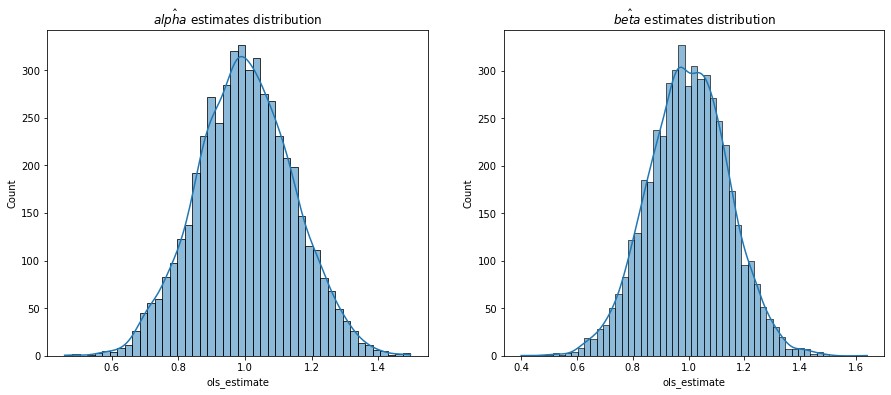

In [9]:
fig_std_normal, stats_std_normal = run_simulations(M, N, dist = 'std_normal')
stats_std_normal

(a) Given that the OLS estimator is unbiased, $\hat{\beta}$ defined as $\hat{\beta}= (X'X)^{-1}X'Y$ has a normal distribution: 

$$\hat{\beta} \sim \mathcal{N}(\beta, \sigma^2 (X'X)^{-1})$$

Here, we have $\beta = 1$. So, simplifying, we get $-$
$$\hat{\beta} = (X'X)^{-1}X'Y = (X'X)^{-1}X'(X\beta + e) = \beta + (X'X)^{-1}X'\mathcal{N}(0, \sigma^2 I) \sim \mathcal{N}(1, \sigma^2 (X'X)^{-1}) \sim \mathcal{N}\left(1, \dfrac{\sigma^2}{n Var(X)}\right)$$

Thus we find that asymtotically, $\hat{\beta}$ follows a normal distribution with $\mu = 1$ and variance $= 0$ as $n$ increases. Similarly, we also know $\hat{\alpha}$ is an unbiased estimator for the intercept since:

$$ E(\hat{\alpha}) = E(\bar{Y} - \hat{\beta}\bar{X}) = \beta_0 + \bar{X}E(\beta - \hat{\beta}) + E(e) = \alpha + \bar{X}[E(\beta) - E(\hat{\beta})] = \alpha $$

Since $var(\alpha) = \dfrac{\sigma^2}{n} \left(1 + \dfrac{\bar{x}^2}{Var(X)} \right)$ $-$ we can see that asympotically, $\hat{\alpha}$ also follows a normal distribution with $\mu = 1$ and variance $= 0$ as $n$ increases.

Thus, both estimators are asymptotically unbiased and consistent and their variances converge to $0$ as $n$ increases.

(d) The theoretical and simulated distributions match, i.e. we can see simulated mean to be almost 1 which is equal to the theoretical mean.

## 2. For $X$ and $e$ with Standard Normal distribution with $\rho_{xe} = 0.5$

Covariance Matrix: 

[[1.  0.5]
 [0.5 1. ]]


,mean,standard_deviation
alpha_hat,0.998265,0.124791
beta_hat,1.500581,0.127558


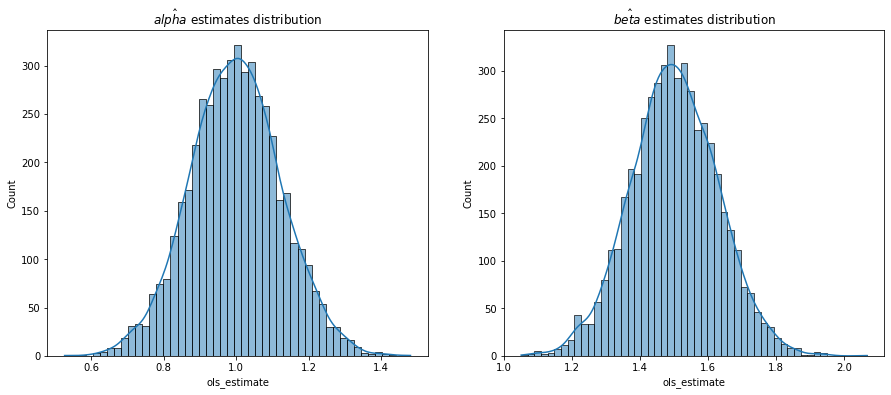

In [10]:
fig_std_normal_corr, stats_std_normal_corr = run_simulations(M, N, dist = 'correlated_normal')
stats_std_normal_corr

(a) Since $X$ and $e$ are correlated, then $\hat{\beta}$ **(violation of the exogenous property as $E(e \mid x) \neq 0$)** is definitely **not unbiased and not consistent** because of its correlation with the residuals. Since we're still following the normal distributions, $\hat{\alpha}$ is unbiased and follows a normal distribution. As $n \to \infty$, then the asymtotic distribution for both $\hat{\alpha}$ and $\hat{\beta}$ should be normal because of **CLT**

(d) The simulations confirm the theoretical properties - $\hat{\beta}$ is biased since its mean is different from $\beta$ and $\hat{\alpha}$ has a mean very close to 1 which confirms that it is unbiased. We can see from the shape of the plots that the limiting distributions for both OLS estimators are normal distributions

## 3. For $X$ and $e$ with Standard t-distribution

,mean,standard_deviation
alpha_hat,1.001711,0.183964
beta_hat,1.001826,0.152263


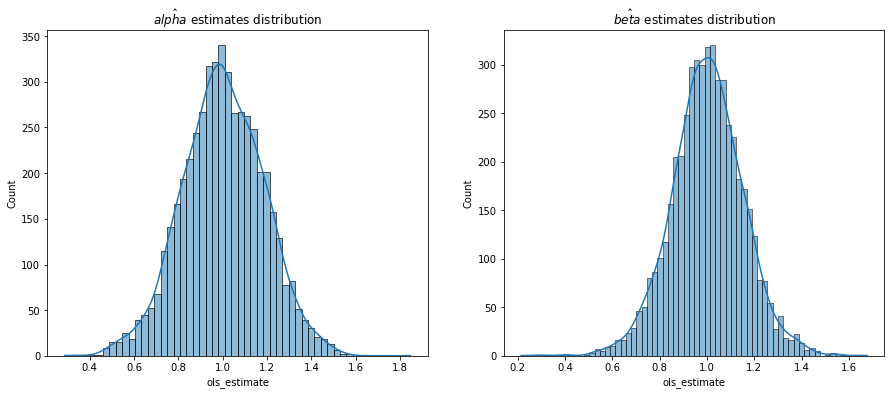

In [11]:
fig_std_t, stats_std_t = run_simulations(M, N, dist = 't_dist')
stats_std_t

(a) Similar to Q1, we know $\hat{\beta} = (X'X)^{-1}X'Y = (X'X)^{-1}X'(X\beta + e)$. Now, since we know that $e \sim t(\nu = 5)$, therefore, we get -
$$\hat{\beta} = \beta + (X'X)^{-1}X't(\nu = 5)$$

We know that for $\nu > 1$ ($5$ degrees of freedom here), the mean is $0$ and the variance is $\dfrac{\nu}{\nu - 2} = \dfrac{5}{3}$. This means that the OLS estimator $\hat{\beta}$ is unbiased since using mean of $0$, we get $E[\hat{\beta}] = \beta$. Thus the theoretical distribution of $\hat{\beta}$ is $-$

$$\hat{\beta} \sim \mathcal{t}\left(\nu = 5, \mu = 0, \sigma^2 = \dfrac{5(X'X)^{-1}}{3}\right) = \sim t\left(\nu = 5, \mu = 0, \sigma^2 = \dfrac{5}{3 n Var(X)}\right)$$

Thus, we can see that $\hat{\beta}$ is consistent as well.

For univariate cases, if we consider $aT_1 + bT_2$ where $T_i$ is $t$ distributed with mean $m_1,m_2$, variance $s_1,s_2$ and with same degrees of freedom $\nu$. Let us define $T := [T_1,T_2]'$ which is a bivariate $t$ distribution with zero covariance by stacking the $T_1$ and $T_2$ into a vector. Then we find that $aT_1 + bT_2 = [a,b]T$. Applying this, $aT_1 + bT_2$ is univariate $t$ distributed with the same $\nu$ degrees of freedom, whose mean is $am_1 + bm_2$ and variance is $a^2s_1 + b^2s_2$. 

Since $\hat{\alpha} = \hat{y} - X\beta - e$ and we know from above that linear combination of univariate $t$-distribution would be a $t$-distribution as well, $\hat{\alpha} = \hat{y} - X\beta - e \sim t\left(\nu = 5, \mu = 1, \sigma^2 = \dfrac{25(X'X)^{-1}}{18}\right)$.

Since the errors are not normal, the estimators are not efficient 

Thus, this shows that $\alpha$ is unbiased estimator as well. Both $\hat{\alpha}$ and $\hat{\beta}$ are asymtotically normal as $n \to \infty$ using CLT

(d) Comparing our theoretical derivations with the simulated means and std deviations, we find that they both are close to $1$ which proves the unbiasedness of the estimators. We can also see that both are asymtotic normal distributions (property of t-distributions).

## 4. For $X$ and $e$ with Uniform Distribution

,mean,standard_deviation
alpha_hat,1.501738,0.082620
beta_hat,0.997228,0.143372


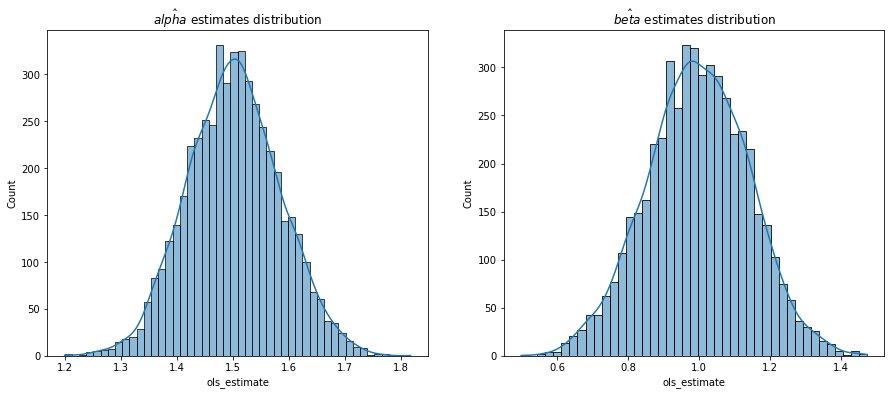

In [12]:
fig_uniform, stats_uniform = run_simulations(M, N, dist = 'uniform_dist')
stats_uniform

(a) Since we know that $e \sim U(0,1)$, therefore, we can calculate -

$$ E(\hat{\beta}) = E[(X'X)^{-1}X'(X\beta + e)] = \beta +  E[(X'X)^{-1}X'e] = \beta +  E\left[E\left[(X'X)^{-1}X'e \mid X\right]\right] $$
$$ \\= \beta +  E\left[(X'X)^{-1}X'E\left[e \mid X \right]\right] = \beta $$

Thus, $\hat{\beta}$ is unbiased and $Var(\hat{\beta}) = \dfrac{(X'X)^{-1}}{12} = \dfrac{1}{12 n Var(X)}$. Since $Var(\hat{\beta}) \to 0$ as $n \to \infty$, the estimator is also consistent.

Similarly for $\hat{\alpha}$, we get:

$$ E(\hat{\alpha}) = E(\bar{Y} - \hat{\beta}\bar{X}) = \beta_0 + \bar{X}E(\beta - \hat{\beta}) + E(e) = \alpha + \bar{X}[E(\beta) - E(\hat{\beta})] + E(e) = \alpha + E(e) = \alpha + 1/2 = 1.5$$

Thus, we see that the estimator $\hat{\alpha}$ is also unbiased. 

(d) As we can see from the simulation vs theoretical distributions, we see that they are identical and asymtotic distributions are normal.

## 5.
Experiment with different sample sizes i.e. values of N = 100, 500 .... You do not have to report the results in detail but describe the effect of N on the OLS estimators in the questions above

,mean,standard_deviation
alpha_hat,1.000110,0.012873
beta_hat,1.000047,0.009934


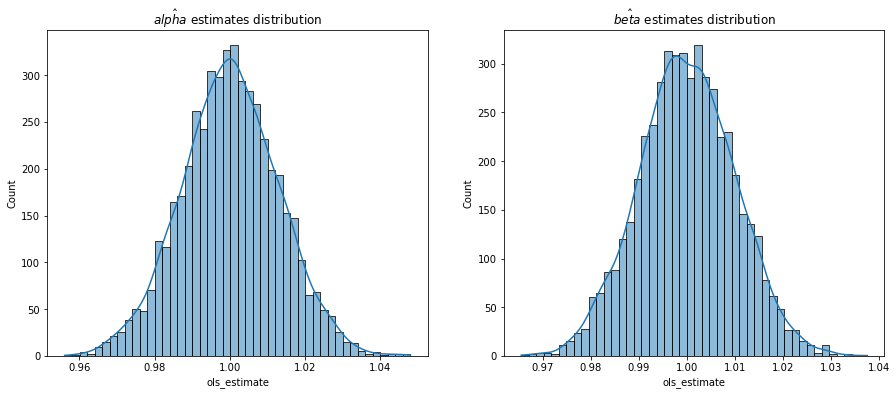

In [13]:
fig_std_t_test, stats_std_t_test = run_simulations(M = 5000, N = 10000, dist = 't_dist')
stats_std_t_test

,mean,standard_deviation
alpha_hat,1.50007,0.005803
beta_hat,0.99980,0.010049


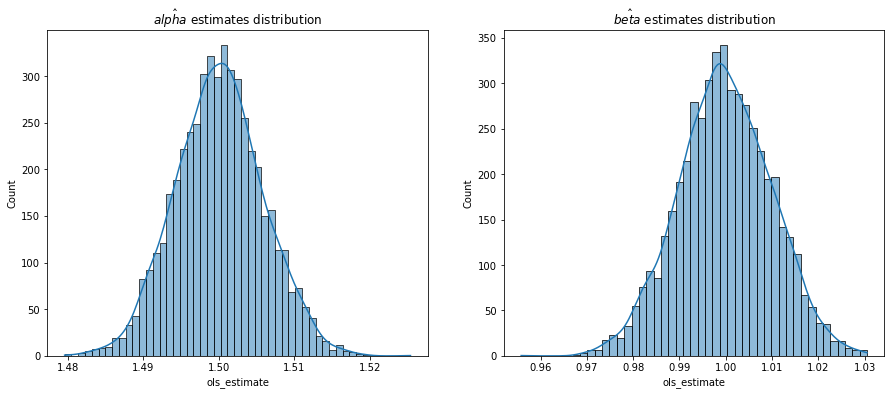

In [14]:
fig_uniform_test, stats_uniform_test = run_simulations(M = 5000, N = 10000, dist = 'uniform_dist')
stats_uniform_test

Covariance Matrix: 

[[1.  0.5]
 [0.5 1. ]]


,mean,standard_deviation
alpha_hat,1.000126,0.008667
beta_hat,1.500083,0.008508


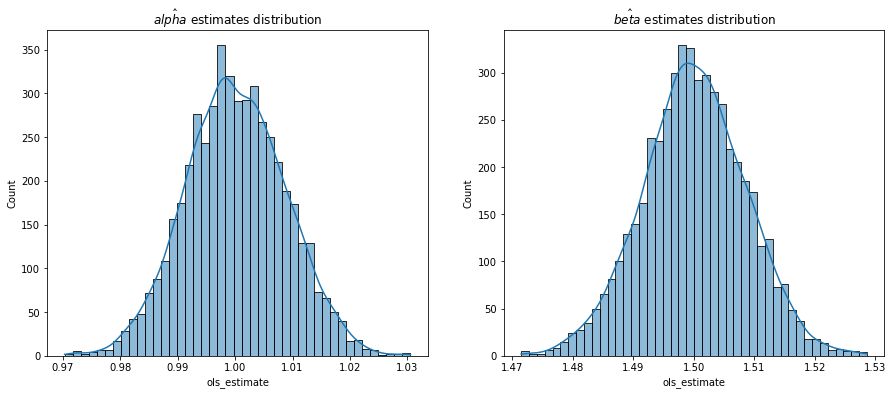

In [15]:
fig_std_normal_corr_test, stats_std_normal_corr_test = run_simulations(M = 5000, N = 10000, dist = 'correlated_normal')
stats_std_normal_corr_test

,mean,standard_deviation
alpha_hat,0.999928,0.009872
beta_hat,0.999963,0.010000


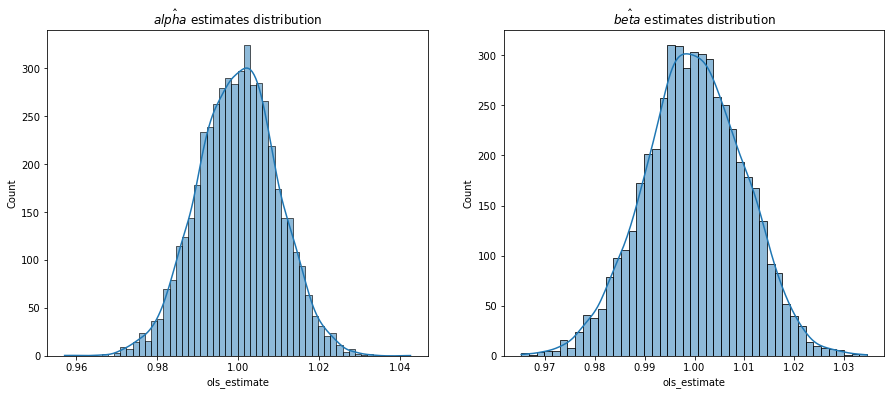

In [16]:
fig_std_normal_test, stats_std_normal_test = run_simulations(M = 5000, N = 10000, dist = 'std_normal')
stats_std_normal_test

As we can see from the above simulations with $N = 10000$ (tried $N = 500, 1000, 5000$), all of them fit a normal distribution with mean $\mu$(differs - its $1$ for unbiased estimators and $1.5$ for biased estimators) and variances close to $0$. The means do not change at significantly on changing $N$, but we see a general trend that variances $\to 0$ $-$ which tells us that these distributions are asymtotically consistent.